# Symmetries

We create patterns based on a basic shape onto which we apply a subset
of the 17 symmetries of the plane.

<img src="img/basic_shape.png" alt="basic shape" width="20%">

In [1]:
# Imports
import math
from math import sin, cos, pi, tan

from shapely.geometry import Polygon, MultiPolygon
from shapely import affinity, centroid, polygons

In [2]:
import sys
sys.path.append('../')  # Add the parent directory to Python path
from polygon_utils import (
    create_regular_polygon,
    plot_polygon_dict,
    center_frame,
    blue_plot,
    save_polygon_list_to_svg,
    add_tile,
    crop_and_save_tile,
)

## Parameters

In [3]:
# DRAWING PARAMS:
drawing_height = 300
drawing_width = 1200
tabica_height = 170
tabica_width = 906

triangle_radius = 42

frame_shift = -4  # move box that selects region of interest down by Xmm
INSET_DISTANCE = 3.2   # X ratio gives gaps of about 2Xmm solid channels

bottom_margin = 26 # solid margin, at bottom of step
top_margin = tabica_height - 120 - bottom_margin # solid margin, at bottom of step

side_margin = 26 # solid margin left and right

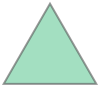

In [4]:
triangle = create_regular_polygon(0,0, triangle_radius, 3)
triangle_up = affinity.rotate(triangle, 90, origin="centroid")
triangle_up

<img src="img/basic_shape.png" alt="basic shape" width="20%">

In [5]:
L = triangle_radius*sin(pi/3)*2

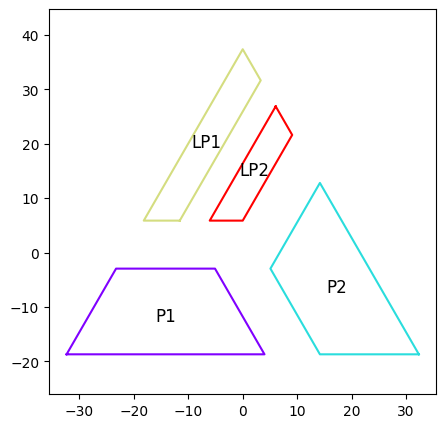

In [6]:
polygon_dict = {}
# polygon_dict['S0'] = triangle_up

L = triangle_radius*sin(pi/3)*2 # triangle side length
h = triangle_radius*cos(pi/3)

p1 = Polygon([(-L/2,-h), (0, -h), (-L/8, -h+L/8/tan(pi/6)), (-L/2+L/8, -h+L/8/tan(pi/6))])

# We generate slices of the 4-polygon by intersecting it with a rectangle
lp1_intersecting_rectangle = Polygon([(-triangle_radius, -triangle_radius/2), 
                                      (-triangle_radius, -triangle_radius/2+L/22/tan(pi/6)),  # 32
                                      (triangle_radius/4, -triangle_radius/2+L/22/tan(pi/6)), 
                                      (triangle_radius/4, -triangle_radius/2)])

lp2_intersecting_rectangle = Polygon([(-triangle_radius, -triangle_radius/4), 
                                      (-triangle_radius, -triangle_radius/4+L/16/tan(pi/6)), 
                                      (triangle_radius/4, -triangle_radius/4+L/16/tan(pi/6)), 
                                      (triangle_radius/4, -triangle_radius/4)])

lp1 = lp1_intersecting_rectangle.intersection(p1)
lp1 = affinity.translate(lp1, 4, 4*tan(pi/6))
lp1 = affinity.rotate(lp1, -120, origin=(0,0))

lp2 = lp2_intersecting_rectangle.intersection(p1)
lp2 = affinity.translate(lp2, 4, 4*tan(pi/6))
lp2 = affinity.rotate(lp2, -120, origin=(0,0))

p1 = affinity.translate(p1, 4, 4*tan(pi/6))
p2 = affinity.rotate(p1, 2*60, origin=(0,0))


# lp2 = Polygon([(-L/2, -h), (0, -h), (-L/32, -h+L/32/tan(pi/6)), (-L/2+L/32, -h+L/32/tan(pi/6))])

polygon_dict['P1'] = p1
polygon_dict['P2'] = p2
polygon_dict['LP1'] = lp1
polygon_dict['LP2'] = lp2
plot_polygon_dict(polygon_dict)

In [7]:
x_offset = L
y_offset = 0

translated_polygons_1 = {
    f"{key}-t": affinity.translate(poly, x_offset, y_offset) for key, poly in polygon_dict.items()
}

translated_polygons_2 = {
    f"{key}-tt": affinity.rotate(poly, 60, origin=(0,0)) for key, poly in translated_polygons_1.items()
}

super_polys = { **polygon_dict, **translated_polygons_1, **translated_polygons_2}


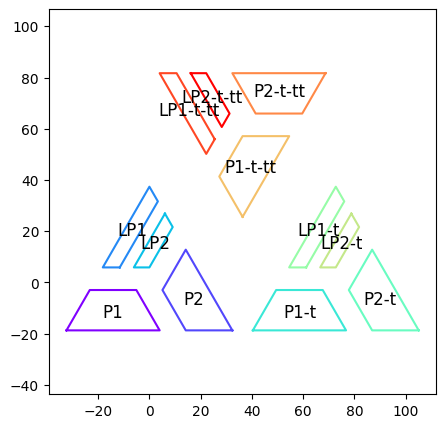

In [8]:
plot_polygon_dict(super_polys)

In [9]:
def translate_poly(polygons, x_offset=L, y_offset=0):
    if isinstance(polygons, list):
        return [affinity.translate(poly, x_offset, y_offset) for poly in polygons]
    elif isinstance(polygons, MultiPolygon):
        return affinity.translate(polygons, x_offset, y_offset)
    else:
        raise ValueError("Input must be a list of polygons or a MultiPolygon")

def rotate_poly(polygons, angle=60, origin="centroid"):
    # create MultiPolygon from list of polygons
    if isinstance(polygons, list):
        multi_poly = MultiPolygon(polygons)
    elif isinstance(polygons, MultiPolygon):
        multi_poly = polygons
    else:
        raise ValueError("Input must be a list of polygons or a MultiPolygon")
    return affinity.rotate(multi_poly, angle, origin=origin)

def mirror_vertical(polygons):
    if isinstance(polygons, list):
        return [affinity.scale(poly, xfact=1, yfact=-1, origin=(0,0)) for poly in polygons]
    elif isinstance(polygons, MultiPolygon):
        return affinity.scale(polygons, xfact=1, yfact=-1, origin=(0,0))
    else:
        raise ValueError("Input must be a list of polygons or a MultiPolygon")

def mirror_horizontal(polygons):
    if isinstance(polygons, list):
        return [affinity.scale(poly, xfact=-1, yfact=1, origin=(0,0)) for poly in polygons]
    elif isinstance(polygons, MultiPolygon):
        return affinity.scale(polygons, xfact=-1, yfact=1, origin=(0,0))
    else:
        raise ValueError("Input must be a list of polygons or a MultiPolygon")

def translate_and_rotate(polygons):
    return rotate_60(translate_right(polygons))
    

In [10]:
initial_polygon_list = list(polygon_dict.values())

In [11]:
t1 = rotate_poly(initial_polygon_list, angle=-120, origin=(0,0))

# t2 = translate_poly(t1, x_offset=L, y_offset=0)

t3 = rotate_poly(initial_polygon_list, angle=60, origin=(0,0))
t3 = translate_poly(t3, L/2, h)

t4 = mirror_vertical(t3)
t4 = translate_poly(t4, 0, 2*triangle_radius)

t5 = mirror_vertical(translate_poly(t1, L, 0)) 
t5 = translate_poly(t5, 0, 2*triangle_radius)



base_shape_3_1 = [t1, t3, t4, t5]
final_poly_combination = list(base_shape_3_1)
for i in range(-2,15):
    if i == 0:
        continue
    else:
        final_poly_combination += translate_poly(base_shape_3_1, i*L, 0)



In [12]:
tile_31 = add_tile(905, 170, final_poly_combination, center_tile = False, up_shift=0)
final_poly_combination = translate_poly(final_poly_combination, 0, h + 23.7)

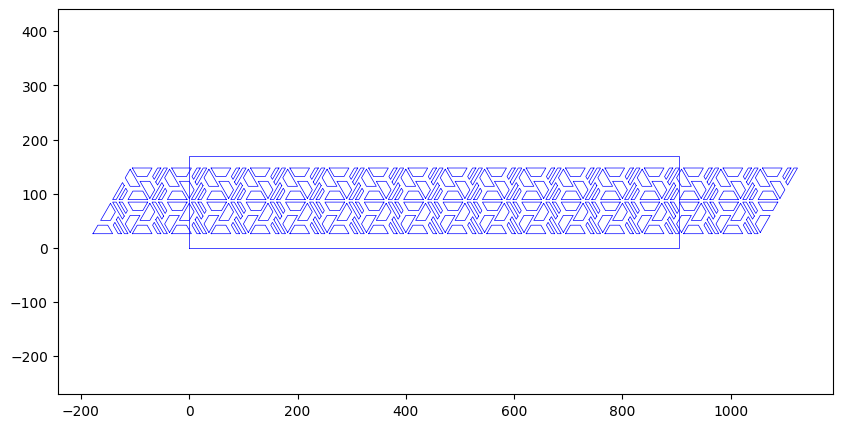

In [13]:
blue_plot(final_poly_combination + [tile_31])

In [14]:
side_margin = 16 # solid margin left and right
inner_tile = Polygon([[side_margin,0],
                  [tabica_width - side_margin, 0],
                  [tabica_width - side_margin, 0 + tabica_height],
                  [side_margin, 0 + tabica_height]])

poly_crop = crop_and_save_tile(final_poly_combination, tile_31, inner_tile, "31", save_holes=False)

272


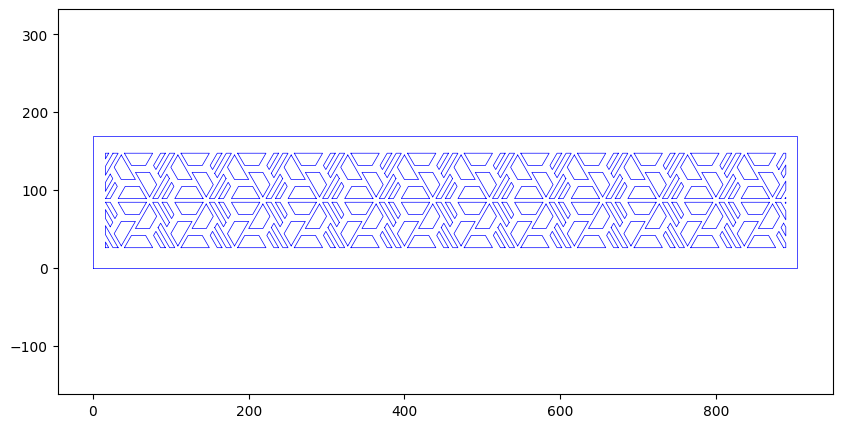

In [15]:
blue_plot(poly_crop  + [tile_31])

In [16]:
# remove holes that are too small
final_export_list = [
    p for p in poly_crop 
    if hasattr(p, 'area') and p.area >= 21
]

In [17]:
# save to svg
save_polygon_list_to_svg(final_export_list +  [tile_31], "final_poly_combination.svg")
